In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random


### Get Data

In [ ]:
# df_train = pd.read_csv('audio_data7_spec_train.csv')
# # Extract MFCC feature columns
# X_train_val = df_train.iloc[:,5:].values

# # Convert labels to numeric numbers (0 for cat, 1 for dog)
# y_train_val = df_train["label"].map({"frog": 0,"donkey": 1,"cat": 2,"monkey": 3,"baby sheep": 4,"bird": 5,"lion": 6,"cow": 7,"dog": 8,"chicken": 9}).values

# # First split: train + val and test
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)


# df_test = pd.read_csv('audio_data7_spec_test.csv')
# X_test = df_test.iloc[:,5:].values
# y_test = df_test["label"].map({"frog": 0,"donkey": 1,"cat": 2,"monkey": 3,"baby sheep": 4,"bird": 5,"lion": 6,"cow": 7,"dog": 8,"chicken": 9}).values


# # Print the sizes of the splits
# print(f'Training set size: {len(X_train)}')
# print(f'Validation set size: {len(X_val)}')
# print(f'Test set size: {len(X_test)}')

C:\Users\travi\AppData\Local\Temp\ipykernel_37968\882814093.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('audio_data7_spec_train.csv')


Training set size: 5008
Validation set size: 884
Test set size: 240


C:\Users\travi\AppData\Local\Temp\ipykernel_37968\882814093.py:12: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('audio_data7_spec_test.csv')


In [14]:
df_train = pd.read_csv('audio_data7_spec_train.csv')
# Extract MFCC feature columns
X_train = df_train.iloc[:,5:].values

# Convert labels to numeric numbers (0 for cat, 1 for dog)
y_train = df_train["label"].map({"frog": 0,"donkey": 1,"cat": 2,"monkey": 3,"baby sheep": 4,"bird": 5,"lion": 6,"cow": 7,"dog": 8,"chicken": 9}).values


df_test = pd.read_csv('audio_data7_spec_test.csv')
X_val_test = df_test.iloc[:,5:].values
y_val_test = df_test["label"].map({"frog": 0,"donkey": 1,"cat": 2,"monkey": 3,"baby sheep": 4,"bird": 5,"lion": 6,"cow": 7,"dog": 8,"chicken": 9}).values

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)


# Print the sizes of the splits
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

C:\Users\travi\AppData\Local\Temp\ipykernel_37968\2482169681.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('audio_data7_spec_train.csv')
C:\Users\travi\AppData\Local\Temp\ipykernel_37968\2482169681.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('audio_data7_spec_test.csv')


Training set size: 5892
Validation set size: 120
Test set size: 120


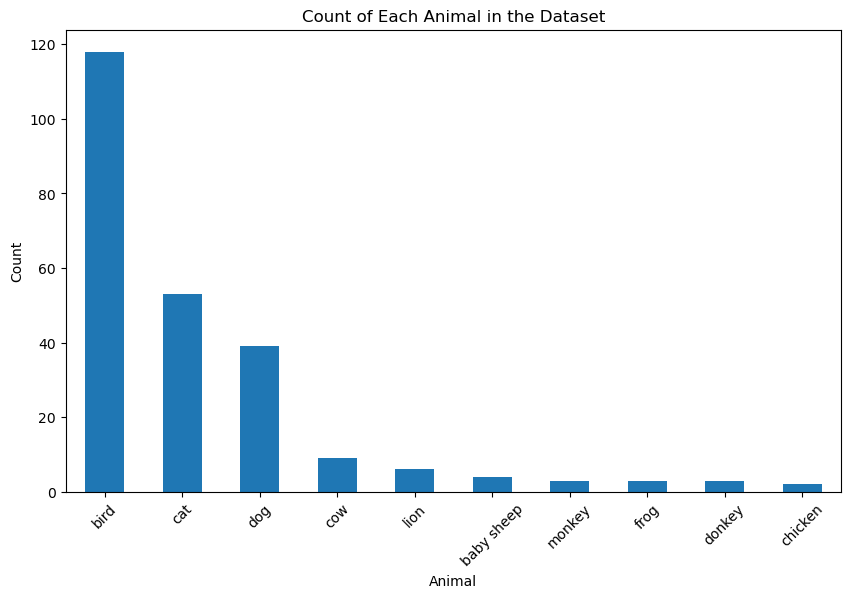

In [15]:
label_counts = df_test['label'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Count of Each Animal in the Dataset')
plt.xticks(rotation=45)
plt.show()

In [16]:
for x in X_train:
    print(len(x))
    break

12800

In [17]:
def reshape_mel_spectrogram(mel_vector, height=128, width=100):
    padded = np.pad(mel_vector, (0, height * width - len(mel_vector)), mode='constant')
    return padded.reshape(height, width)

# Reshape all mel spectrogram data
X_train = np.array([reshape_mel_spectrogram(x) for x in X_train])
X_val = np.array([reshape_mel_spectrogram(x) for x in X_val])
X_test = np.array([reshape_mel_spectrogram(x) for x in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [18]:
class SpecDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = SpecDataset(X_train_tensor, y_train_tensor)
val_dataset = SpecDataset(X_val_tensor, y_val_tensor)
test_dataset = SpecDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Create Model

In [19]:
# Model fo audio_data2
class CNN_Audio2(nn.Module):
    def __init__(self):
        super(CNN_Audio2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [42]:
class CNN(nn.Module):
    def __init__(self, num_conv_layers, num_filters, kernel_size, dropout):
        super(CNN, self).__init__()
        layers = []
        in_channels = 1  # Since input has 1 channel

        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2, 2))  # Halves the height & width
            in_channels = num_filters

        self.conv = nn.Sequential(*layers)

        # Compute the flattened size dynamically
        dummy_input = torch.randn(1, 1, 128, 100)
        with torch.no_grad():
            output_size = self.conv(dummy_input).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(output_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 89)  # Assuming 89 output classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten before passing to FC layer
        x = self.fc(x)
        return x

### Random Search

In [43]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64],
    'num_conv_layers': [2, 3, 4, 5],
    'kernel_sizes': [(2,2), (3, 3)],
    'num_filters': [16, 32, 64, 128, 256],
    'dropout': [0.3, 0.5, 0.7],
    'optimizer': ['adam', 'sgd']
}

def sample_hyperparameters():
    return {k: random.choice(v) for k, v in param_grid.items()}

In [44]:
def train_and_evaluate(hyperparams, train_loader, val_loader, device, early_stopping_patience=3):
    model = CNN(
        num_conv_layers=hyperparams['num_conv_layers'],
        num_filters=hyperparams['num_filters'],
        kernel_size=hyperparams['kernel_sizes'],
        dropout=hyperparams['dropout']
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate']) \
        if hyperparams['optimizer'] == 'adam' else optim.SGD(model.parameters(), lr=hyperparams['learning_rate'])

    best_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(30):  # Train for a maximum of 30 epochs
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total

        # Check for early stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1} with best validation accuracy: {best_accuracy}')
            break

    return best_accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_hyperparams = None
best_accuracy = 0

for _ in range(20):  # Run random trials
    hyperparams = sample_hyperparameters()
    accuracy = train_and_evaluate(hyperparams, train_loader, _loader, device)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparams = hyperparams

    print(f"Trial: {hyperparams}, Accuracy: {accuracy:.4f}")

print(f"Best Hyperparameters: {best_hyperparams}, Best Accuracy: {best_accuracy:.4f}")


KeyboardInterrupt: 

### Train Model

In [47]:
best_hyperparams = {  # Replace with your best hyperparams
    'learning_rate': 0.001,
    'num_conv_layers': 3,
    'kernel_sizes': (3, 3),
    'num_filters': 16,
    'dropout': 0.5,
    'optimizer': 'adam'
}

early_stopping_patience = 3

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Define the path where you want to save the model
model_save_path = "final_model_CNN_Spec.pth"

def train_final_model(hyperparams, train_loader, val_loader, device, epochs=10):
    model = CNN(
        num_conv_layers=hyperparams['num_conv_layers'],
        num_filters=hyperparams['num_filters'],
        kernel_size=hyperparams['kernel_sizes'],
        dropout=hyperparams['dropout']
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate']) \
        if hyperparams['optimizer'] == 'adam' else optim.SGD(model.parameters(), lr=hyperparams['learning_rate'])
    

    best_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader)}")

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total

        # Check for early stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0
            # Save the best model
            save_model(model, model_save_path)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1} with best validation accuracy: {best_accuracy}')
            break

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = train_final_model(best_hyperparams, train_loader, val_loader, device, epochs=30)

Epoch 0, Loss: 1.7891307389413988
Model saved to final_model_CNN_Spec.pth
Epoch 1, Loss: 0.5294287588145282
Model saved to final_model_CNN_Spec.pth
Epoch 2, Loss: 0.22023751950143156
Epoch 3, Loss: 0.12457114161067717
Model saved to final_model_CNN_Spec.pth
Epoch 4, Loss: 0.07562133249121944
Model saved to final_model_CNN_Spec.pth
Epoch 5, Loss: 0.0586411482619902
Model saved to final_model_CNN_Spec.pth
Epoch 6, Loss: 0.06294603541336369
Epoch 7, Loss: 0.05892050513192206
Epoch 8, Loss: 0.04806746259202702
Early stopping at epoch 9 with best validation accuracy: 0.775


In [ ]:
# model = CNN_Audio2()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 50
# train_losses = []
# val_losses = []
# best_accuracy = 0.0
# epochs_without_improvement = 0

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs).squeeze(1)  # Ensure outputs are of shape [batch_size]
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     train_losses.append(running_loss / len(train_loader))

#     # Validation loss
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             outputs = model(inputs).squeeze(1)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#     val_losses.append(val_loss / len(val_loader))

#     # Evaluate on validation set
#     model.eval()
#     correct, total = 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = correct / total

#     # Check for early stopping
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         epochs_without_improvement = 0
#     else:
#         epochs_without_improvement += 1

#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

# print("Training complete!")


Epoch 1/50, Training Loss: 1.4559461048671178, Validation Loss: 0.6977795853334314
Epoch 2/50, Training Loss: 0.3814046863805164, Validation Loss: 0.3082313655930407
Epoch 3/50, Training Loss: 0.13323316256237494, Validation Loss: 0.23584817097905805
Epoch 4/50, Training Loss: 0.058400467104677646, Validation Loss: 0.12206868569859687
Epoch 5/50, Training Loss: 0.020415198943855895, Validation Loss: 0.1375694588812835
Epoch 6/50, Training Loss: 0.03740103853346369, Validation Loss: 0.15342348770183675
Epoch 7/50, Training Loss: 0.01112209214351152, Validation Loss: 0.12310283328406513
Epoch 8/50, Training Loss: 0.002309077351305682, Validation Loss: 0.11840344480279942
Epoch 9/50, Training Loss: 0.001348438019208102, Validation Loss: 0.13927112315671847
Epoch 10/50, Training Loss: 0.001030339912153091, Validation Loss: 0.127075358218623
Epoch 11/50, Training Loss: 0.0007595827454525687, Validation Loss: 0.12627618272466967
Epoch 12/50, Training Loss: 0.0006227287261250925, Validation L

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

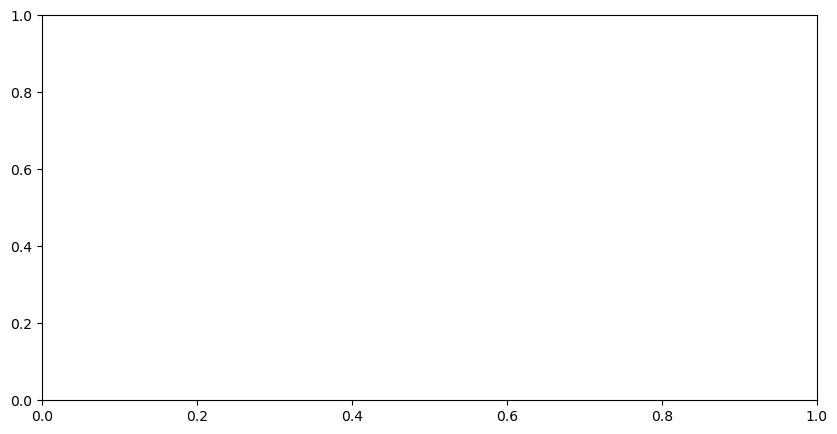

In [77]:
# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9 + 1), train_losses, label='Training Loss')
plt.plot(range(1, 9 + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

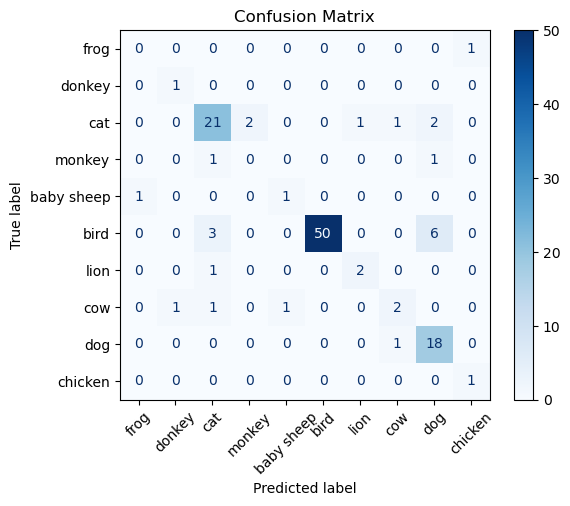

In [48]:
# Evaluate the model on the test set
final_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["frog","donkey","cat","monkey","baby sheep","bird","lion","cow","dog","chicken"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))  # Increase the figure size
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.show()

In [49]:
final_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8


In [50]:
final_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Val Accuracy: {accuracy}")


Val Accuracy: 0.7666666666666667


In [51]:
final_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Train Accuracy: {accuracy}")


Train Accuracy: 0.9996605566870332
